Here im calibrating a SIR model with bayesian inference to get a good sense of how everything works together. The idea is that a trainer does this process automatically and the user only needs to specify the model, the data, the priors and the likehoods. The trainer will take care of the rest.

In [1]:
# Loading watermark to show the version of the used packages
%load_ext watermark

In [2]:
# Importing the required packages
import numpy as np
import pandas as pd
import sunode.wrappers.as_pytensor
import pymc as pm
import arviz as az
from scipy.integrate import odeint
import matplotlib.pyplot as plt


In [3]:
# use watermark to print the version of the packages imported
%watermark -v -p numpy,sunode,pymc,arviz,scipy,networkx

Python implementation: CPython
Python version       : 3.8.15
IPython version      : 8.8.0

numpy   : 1.23.5
sunode  : 0.4.0
pymc    : 5.0.1
arviz   : 0.14.0
scipy   : 1.10.0
networkx: 3.0



In [4]:
# Define the ODE system for scipy and sympy
def sir_scipy(y, t, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I
    dIdt = beta * S * I - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

def sir_sympy(t, y, p):
    return {
        "S": -p.beta * y.S * y.I,
        "I": p.beta * y.S * y.I - p.gamma * y.I,
        "R": p.gamma * y.I,
    }

In [5]:
# lets generate some data folliwing a sir like curve
# parameters
true_beta = 0.4
true_gamma = 0.1
true_y0 = np.array([0.99, 0.01, 0.0])

# time points
t = np.linspace(0, 100, 100)

# y
# solve the ode using sir_scipy
true_y = odeint(sir_scipy, true_y0, t, args=(true_beta, true_gamma))
true_y = pd.DataFrame(true_y, columns=["S", "I", "R"])

<AxesSubplot: title={'center': 'Normalized SIR model'}, xlabel='Time (Days)', ylabel='Normalized population'>

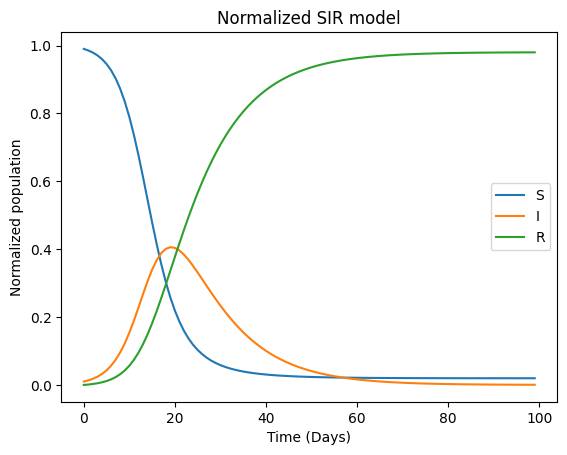

In [6]:
# Just checking the data
true_y.plot(
    title="Normalized SIR model",
    xlabel="Time (Days)",
    ylabel="Normalized population",
)

In [7]:
with pm.Model() as sir_model:
    # Priors for initial condition
    S0 = pm.Uniform("S0", lower=0.9, upper=0.99)
    I0 = pm.Uniform("I0", lower=0, upper=1-S0)
    R0 = pm.Deterministic("R0", 1 - S0 - I0)

    # Priors for parameters
    beta = pm.HalfNormal("beta", sigma=0.25)
    gamma = pm.TruncatedNormal("gamma", mu=0.3, sigma=0.15, lower=0.0, upper=1.0)

    y_pred, _, problem, solver, _, _ = sunode.wrappers.as_pytensor.solve_ivp(
        y0={
	    # The initial conditions of the ode. Each variable
	    # needs to specify a PyTensor or numpy variable and a shape.
	    # This dict can be nested.
            'S': (S0, ()),
            'I': (I0, ()),
            'R': (R0, ()),
        },
        params={
	    # Each parameter of the ode. sunode will only compute derivatives
	    # with respect to PyTensor variables. The shape needs to be specified
	    # as well. It it infered automatically for numpy variables.
	    # This dict can be nested.
            'beta': (beta, ()),
            'gamma': (gamma, ()),
            'extra': np.zeros(1), # This extra parameter is necessary to avoid a bug in sunode
        },
	# A functions that computes the right-hand-side of the ode using
	# sympy variables.
        rhs=sir_sympy,
	# The time points where we want to access the solution
        tvals=t,
        t0=t[0],
    )

    sd = pm.HalfNormal('sd')
    pm.Normal('S_obs', mu=y_pred['S'], sigma=sd, observed=true_y.S)
    pm.Normal('I_obs', mu=y_pred['I'], sigma=sd, observed=true_y.I)


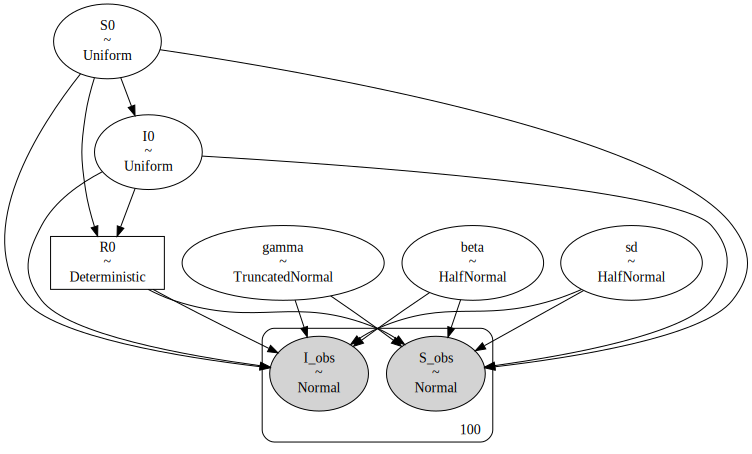

In [8]:
pm.model_to_graphviz(sir_model)

In [ ]:
with sir_model:
    idata = pm.sample(tune=1000, draws=1000, chains=1, cores=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [S0, I0, beta, gamma, sd]


In [ ]:
az.plot_trace(idata)

In [ ]:
with sir_model:
    ppc = pm.sample_posterior_predictive(idata, var_names=['I_obs'])
ppc.posterior_predictive.

In [ ]:
I_ppc = ppc.posterior_predictive["I_obs"]
mean_ppc = I_ppc.mean(dim=["chain", "draw"])


In [ ]:
mean_ppc\
    .to_dataframe()\
    .plot(xlabel="Time (Days)", ylabel="Normalized population", title="Posterior predictive mean")